In [1]:
import os
import sys
import numpy as np
import pandas as pd
import pysindy as ps

sys.path.append('..')
from src.utils import *
from src.configs import *

from matplotlib import rcParams
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
rcParams.update(fig_params)

import warnings

%load_ext autoreload
%autoreload 2

<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
from scipy.integrate import solve_ivp

# Integrator keywords for solve_ivp
integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-12

## Lorenz system

$$ \dot{x} = \sigma (y - x),$$
$$ \dot{y} = x(\rho - z) - y, $$
$$ \dot{z} = x y - \beta z, $$
with $\sigma = 10$, $\rho = 28$, and $\beta = 8/3$.

## Data generation

In [3]:
dt = 0.002

t_train = np.arange(0, 10, dt)
x0_train = [-8, 8, 27]
t_train_span = (t_train[0], t_train[-1])
x_train = solve_ivp(
    lorenz, t_train_span, x0_train, t_eval=t_train, **integrator_keywords
).y.T
x_dot_train_measured = np.array([lorenz(0, x_train[i]) for i in range(t_train.size)])

t_test = np.arange(10, 20, dt)
t_test_span = (t_test[0], t_test[-1])
x0_test = x_train[-1,:]
x_test = solve_ivp(
    lorenz, t_test_span, x0_test, t_eval=t_test, **integrator_keywords
).y.T
x_dot_test_measured = np.array([lorenz(10, x_test[i]) for i in range(t_test.size)])

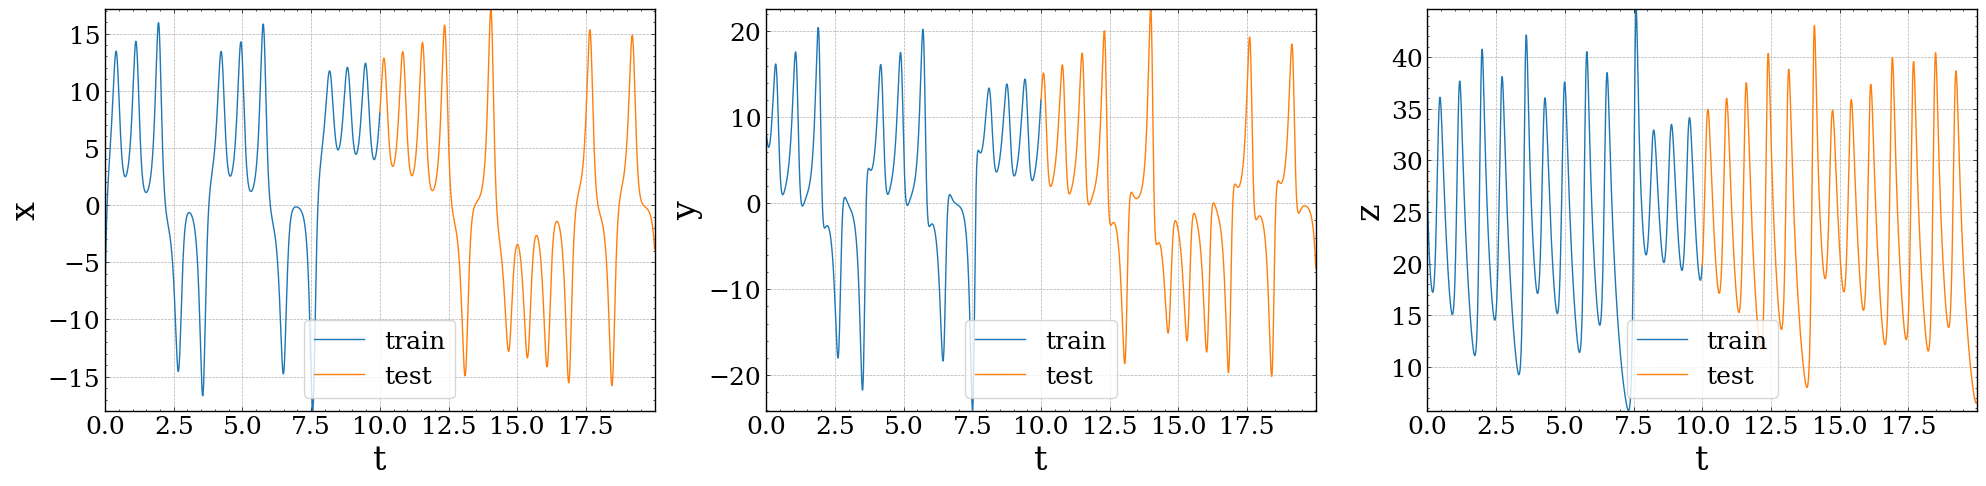

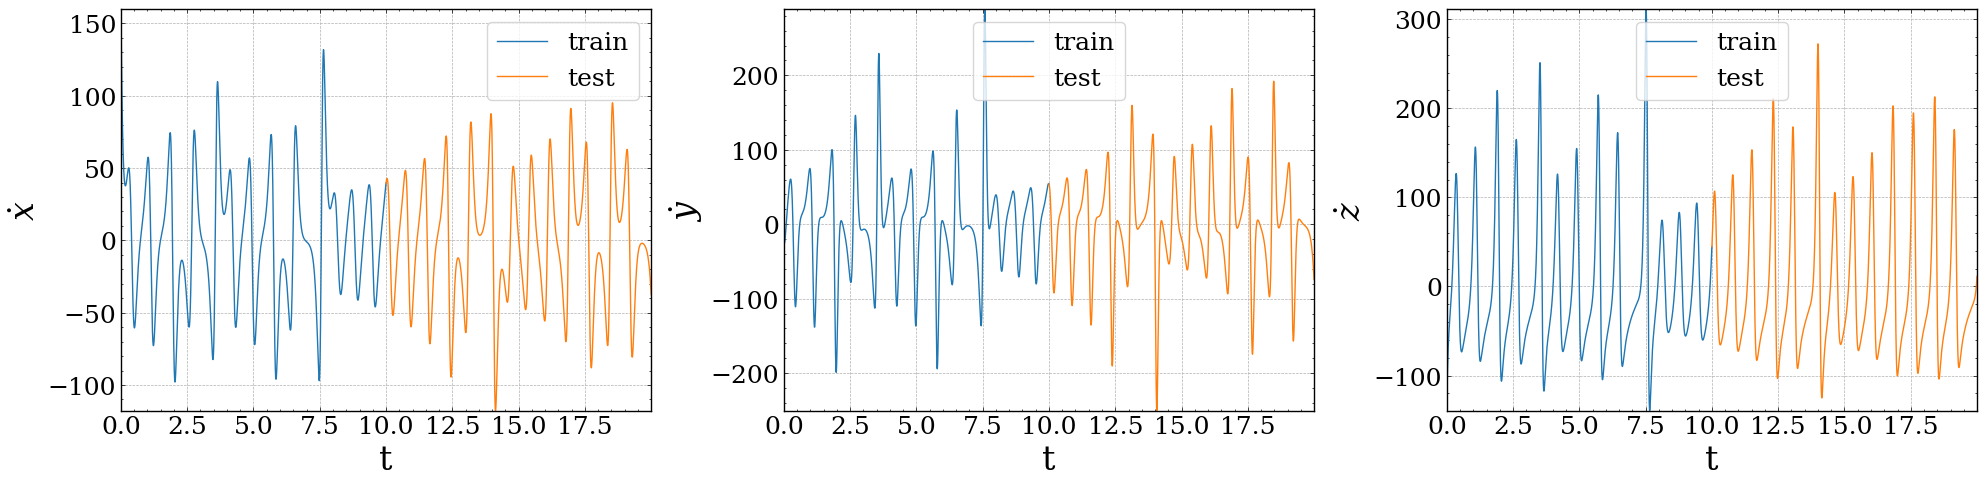

In [4]:
plot_lorenz(x_train, x_dot_train_measured, x_test, x_dot_test_measured, t_train, t_test, feature_name = ["x", "y", "z"])

In [5]:
DEVICE = 'cuda:1' if torch.cuda.is_available() else 'cpu' 
print('Using device:', DEVICE)
DTYPE = torch.float64

Using device: cuda:1


In [8]:
from sklearn.preprocessing import PolynomialFeatures

poly_order = 5
features = ['x', 'y', 'z']
poly = PolynomialFeatures(degree=poly_order, include_bias=False)
x_train_poly = poly.fit_transform(pd.DataFrame(x_train, columns=features))
x_test_poly = poly.transform(pd.DataFrame(x_test, columns=features))

initialization = np.ones(x_train_poly.shape[1])*1.0
learning_rate = 1.0#LinearLR(initial_lr=1.0, decay=1.0)

model = MultiRidge2(lambda_vector=initialization, folds=3, shuffle=True, random_state=42, normalize=True,
                   epochs=500, learning_rate=learning_rate, scoring={'r2': r2_score},
                   verbose=10, device=DEVICE, dtype=DTYPE)
model.fit(x_train_poly, x_dot_train_measured[:] + 0*np.random.randn(x_dot_train_measured.shape[0],x_dot_train_measured.shape[1]), eval_set=(x_test_poly, x_dot_test_measured[:]))

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 1: Train r2: 0.825, Valid r2: 0.824, Test r2: 0.823
Epoch 11: Train r2: 0.928, Valid r2: 0.927, Test r2: 0.925
Epoch 21: Train r2: 0.950, Valid r2: 0.950, Test r2: 0.951
Epoch 31: Train r2: 0.987, Valid r2: 0.987, Test r2: 0.987
Epoch 41: Train r2: 0.994, Valid r2: 0.994, Test r2: 0.994
Epoch 51: Train r2: 0.998, Valid r2: 0.998, Test r2: 0.998
Epoch 61: Train r2: 0.998, Valid r2: 0.998, Test r2: 0.998
Epoch 71: Train r2: 0.999, Valid r2: 0.999, Test r2: 0.998
Epoch 81: Train r2: 0.999, Valid r2: 0.999, Test r2: 0.998
Epoch 91: Train r2: 0.999, Valid r2: 0.999, Test r2: 0.999
Epoch 101: Train r2: 0.999, Valid r2: 0.999, Test r2: 0.999
Epoch 111: Train r2: 0.999, Valid r2: 0.999, Test r2: 0.999
Epoch 121: Train r2: 1.000, Valid r2: 1.000, Test r2: 0.999
Epoch 131: Train r2: 1.000, Valid r2: 1.000, Test r2: 1.000
Epoch 141: Train r2: 1.000, Valid r2: 1.000, Test r2: 1.000
Epoch 151: Train r2: 1.000, Valid r2: 1.000, Test r2: 1.000
Epoch 161: Train r2: 1.000, Valid r2: 1.000, Test r

MultiRidge2(device='cuda:1', dtype=torch.float64, epochs=500, folds=3,
            lambda_vector=tensor([2.9466e-05, 2.2299e-05, 6.2904e-02, 8.7817e-01, 1.4626e-02, 8.9043e-04,
        4.7682e-01, 8.5483e-01, 8.1247e-01, 9.6493e-01, 9.9331e-01, 9.7675e-01,
        9.8392e-01, 9.0921e-01, 3.7592e-01, 9.5390e-01, 9.5033e-01, 8.8243e-01,
        9.2545e-01, 1.0003e+00, 1.0166e+00, 9.5444e-01, 1.0265e+00, 9.9185e-...
        1.0013e+00, 1.0088e+00, 8.8469e-01, 9.7741e-01, 9.9395e-01, 1.0009e+00,
        1.0015e+00, 1.0036e+00, 1.0165e+00, 9.6592e-01, 1.0060e+00, 1.0267e+00,
        9.9258e-01, 9.9952e-01, 1.0077e+00, 1.0336e+00, 1.0028e+00, 9.9050e-01,
        7.8429e-01, 1.0072e+00, 1.0362e+00, 1.0017e+00, 1.0120e+00, 9.0294e-01,
        1.0020e+00], device='cuda:1', dtype=torch.float64),
            learning_rate=1.0, random_state=42,
            scoring={'r2': <function r2_score at 0x7f7c338e4ee0>}, verbose=10)

In [9]:
model.coef_.round(1)

array([[-10. ,  10. ,  -0. ,   0. ,  -0. ,  -0. ,   0. ,   0. ,   0. ,
          0. ,   0. ,   0. ,   0. ,   0. ,   0. ,  -0. ,   0. ,   0. ,
          0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,  -0. ,   0. ,
          0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,
          0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,  -0. ,
         -0. ,   0. ,   0. ,   0. ,  -0. ,  -0. ,   0. ,   0. ,   0. ,
          0. ],
       [ 28. ,  -1. ,   0. ,  -0. ,   0. ,  -1. ,  -0. ,  -0. ,  -0. ,
         -0. ,  -0. ,  -0. ,  -0. ,  -0. ,  -0. ,   0. ,  -0. ,  -0. ,
         -0. ,  -0. ,  -0. ,  -0. ,  -0. ,  -0. ,  -0. ,   0. ,  -0. ,
         -0. ,  -0. ,   0. ,  -0. ,  -0. ,  -0. ,  -0. ,  -0. ,  -0. ,
          0. ,  -0. ,  -0. ,  -0. ,  -0. ,  -0. ,  -0. ,   0. ,   0. ,
          0. ,  -0. ,  -0. ,  -0. ,   0. ,   0. ,  -0. ,  -0. ,  -0. ,
         -0. ],
       [ -0. ,  -0. ,  -2.6,  -0. ,   1. ,   0. ,   0. ,  -0. ,  -0. ,
          0. ,   0. ,  -0. ,   0. ,   0. ,  -

$$ \dot{x} = \sigma (y - x),$$
$$ \dot{y} = x(\rho - z) - y, $$
$$ \dot{z} = x y - \beta z, $$
with $\sigma = 10$, $\rho = 28$, and $\beta = 8/3$.

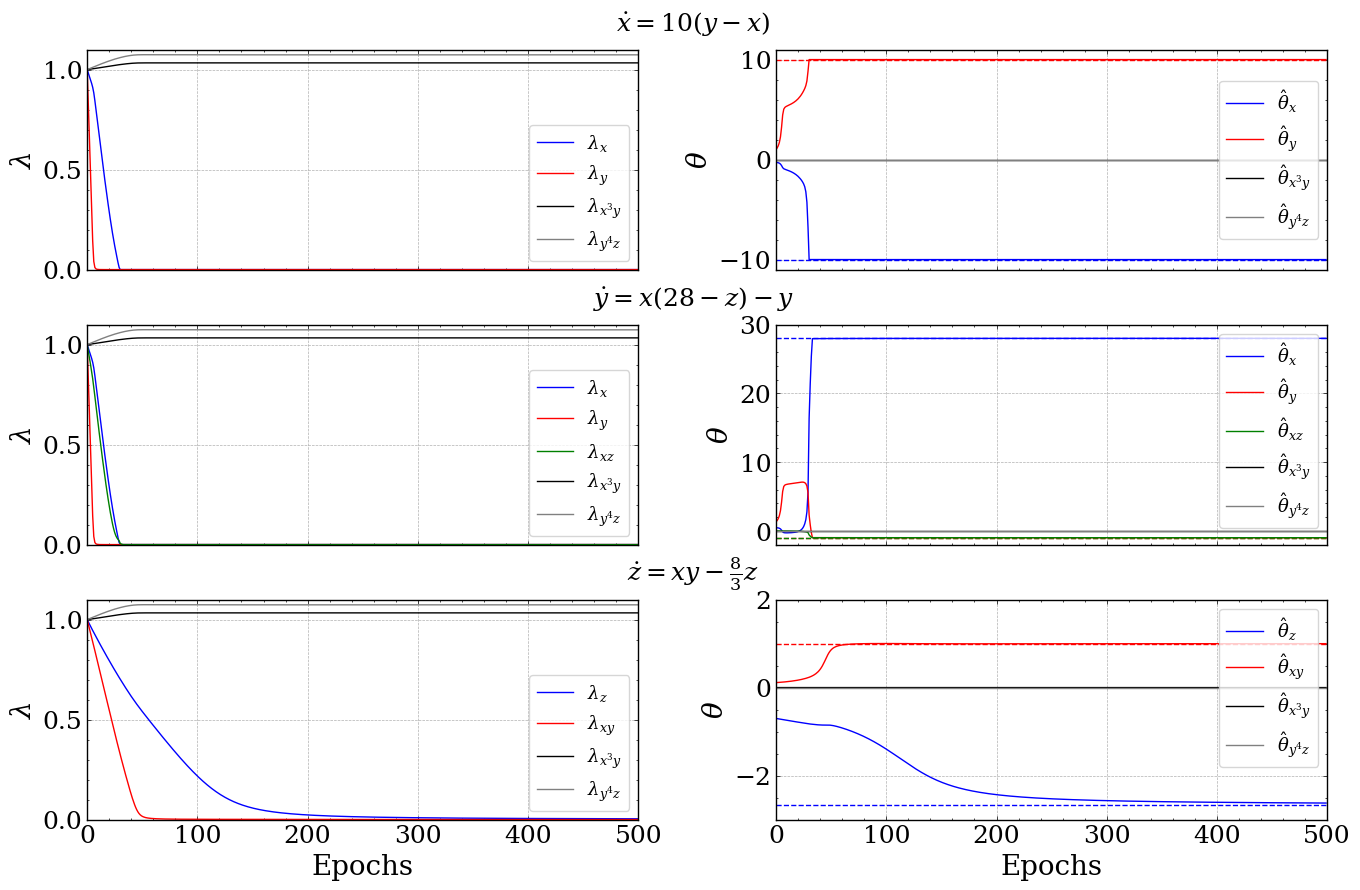

In [12]:
fig_params['axes.labelsize'] = 20
fig_params['xtick.labelsize'] = 18
fig_params['ytick.labelsize'] = 18
fig_params['axes.titlesize'] = 18
fig_params['legend.fontsize'] = 13
fig_params['axes.grid'] = True
rcParams.update(fig_params)

lambda_df = pd.DataFrame(model.history['lambda'], columns=poly.get_feature_names_out())
fig, axes = plt.subplots(3, 2, figsize = (16, 10), gridspec_kw = {"hspace": 0.25, "wspace": 0.25}, sharex = True)
########### First state
coef_x_df = pd.DataFrame(model.history['coef'][:,:,0], columns=poly.get_feature_names_out())
(lambda_df['x']**2).plot(ax=axes[0,0], color='b', label=r'$\lambda_x$')
(lambda_df['y']**2).plot(ax=axes[0,0], color='r', label=r'$\lambda_y$')
(lambda_df['x^3 y']**2).plot(ax=axes[0,0], color='k', label=r'$\lambda_{x^3 y}$')
(lambda_df['y^4 z']**2).plot(ax=axes[0,0], color='grey', label=r'$\lambda_{y^4 z}$')
axes[0,0].set_title(r'$\dot{x} = 10 (y - x)$', y=1.05, x=1.1)
axes[0,0].set_ylabel(r'$\lambda$')
axes[0,0].set_ylim(0,1.1)
axes[0,0].legend()

axes[0,1].axhline(-10, linestyle='--', color='b')#, label=r'$\theta_x$')
axes[0,1].axhline(10, linestyle='--', color='r')#, label=r'$\theta_y$')
coef_x_df['x'].plot(ax=axes[0,1], color='b', label=r'$\hat\theta_x$')
coef_x_df['y'].plot(ax=axes[0,1], color='r', label=r'$\hat\theta_y$')
coef_x_df['x^3 y'].plot(ax=axes[0,1], color='k', label=r'$\hat\theta_{x^3 y}$')
coef_x_df['y^4 z'].plot(ax=axes[0,1], color='grey', label=r'$\hat\theta_{y^4 z}$')
axes[0,1].set_ylabel(r'$\theta$')
axes[0,1].set_ylim(-11,11)
axes[0,1].legend()

########### Second state
coef_x_df = pd.DataFrame(model.history['coef'][:,:,1], columns=poly.get_feature_names_out())
(lambda_df['x']**2).plot(ax=axes[1,0], color='b', label=r'$\lambda_x$')
(lambda_df['y']**2).plot(ax=axes[1,0], color='r', label=r'$\lambda_y$')
(lambda_df['x z']**2).plot(ax=axes[1,0], color='g', label=r'$\lambda_{xz}$')
(lambda_df['x^3 y']**2).plot(ax=axes[1,0], color='k', label=r'$\lambda_{x^3 y}$')
(lambda_df['y^4 z']**2).plot(ax=axes[1,0], color='grey', label=r'$\lambda_{y^4 z}$')
axes[1,0].set_title(r'$\dot{y} = x(28 - z) - y$', y=1.05, x=1.1)
axes[1,0].set_ylabel(r'$\lambda$')
axes[1,0].set_ylim(0,1.1)
axes[1,0].legend()

axes[1,1].axhline(28, linestyle='--', color='b')#, label=r'$\theta_x$')
axes[1,1].axhline(-1, linestyle='--', color='r')#, label=r'$\theta_y$')
axes[1,1].axhline(-1, linestyle='--', color='g')#, label=r'$\theta_{xz}$')
coef_x_df['x'].plot(ax=axes[1,1], color='b', label=r'$\hat\theta_x$')
coef_x_df['y'].plot(ax=axes[1,1], color='r', label=r'$\hat\theta_y$')
coef_x_df['x z'].plot(ax=axes[1,1], color='g', label=r'$\hat\theta_{xz}$')
coef_x_df['x^3 y'].plot(ax=axes[1,1], color='k', label=r'$\hat\theta_{x^3 y}$')
coef_x_df['y^4 z'].plot(ax=axes[1,1], color='grey', label=r'$\hat\theta_{y^4 z}$')
axes[1,1].set_ylabel(r'$\theta$')
axes[1,1].set_ylim(-2, 30)
axes[1,1].legend()

########### Third state
coef_x_df = pd.DataFrame(model.history['coef'][:,:,2], columns=poly.get_feature_names_out())
(lambda_df['z']**2).plot(ax=axes[2,0], color='b', label=r'$\lambda_z$')
(lambda_df['x y']**2).plot(ax=axes[2,0], color='r', label=r'$\lambda_{xy}$')
(lambda_df['x^3 y']**2).plot(ax=axes[2,0], color='k', label=r'$\lambda_{x^3 y}$')
(lambda_df['y^4 z']**2).plot(ax=axes[2,0], color='grey', label=r'$\lambda_{y^4 z}$')
axes[2,0].set_title(r'$\dot{z} = x y - \frac{8}{3} z$', y=1.05, x=1.1)
axes[2,0].set_ylabel(r'$\lambda$')
axes[2,0].set_xlabel('Epochs')
axes[2,0].set_ylim(0,1.1)
axes[2,0].legend()

axes[2,1].axhline(-2.66, linestyle='--', color='b')#, label=r'$\theta_z$')
axes[2,1].axhline(1, linestyle='--', color='r')#, label=r'$\theta_{xy}$')
coef_x_df['z'].plot(ax=axes[2,1], color='b', label=r'$\hat\theta_z$')
coef_x_df['x y'].plot(ax=axes[2,1], color='r', label=r'$\hat\theta_{xy}$')
coef_x_df['x^3 y'].plot(ax=axes[2,1], color='k', label=r'$\hat\theta_{x^3 y}$')
coef_x_df['y^4 z'].plot(ax=axes[2,1], color='grey', label=r'$\hat\theta_{y^4 z}$')
axes[2,1].set_ylabel(r'$\theta$')
axes[2,1].set_xlabel('Epochs')
axes[2,1].set_ylim(-3, 2)
axes[2,1].legend()

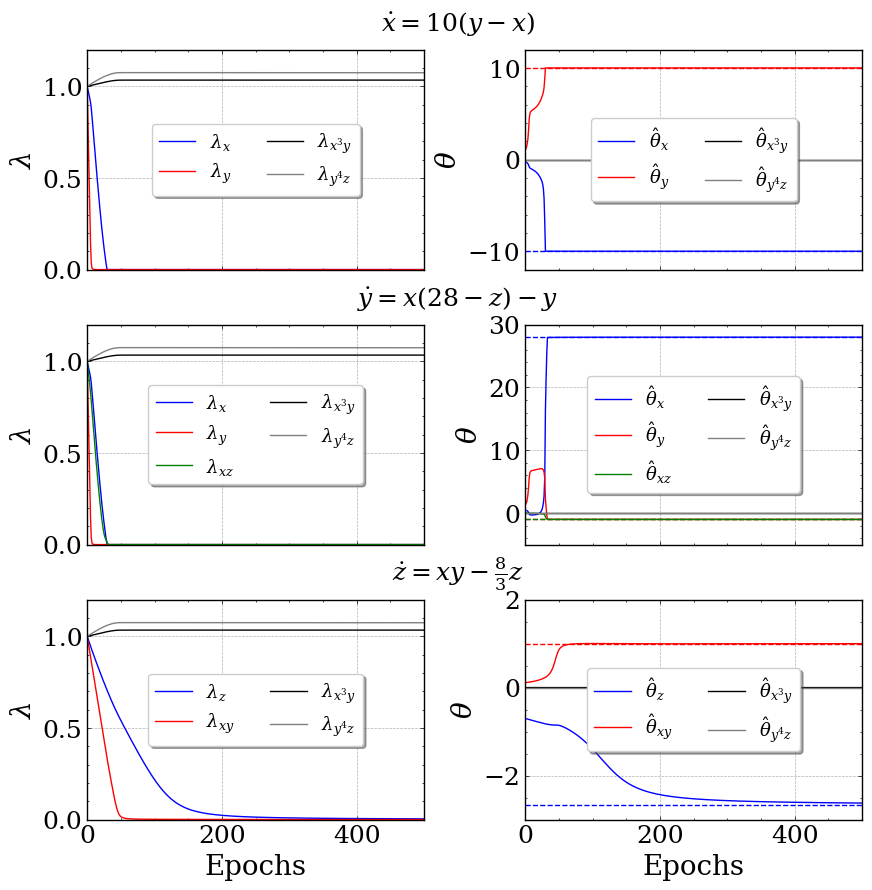

In [33]:
fig_params['axes.labelsize'] = 20
fig_params['xtick.labelsize'] = 18
fig_params['ytick.labelsize'] = 18
fig_params['axes.titlesize'] = 18
fig_params['legend.fontsize'] = 13
fig_params['axes.grid'] = True
rcParams.update(fig_params)

lambda_df = pd.DataFrame(model.history['lambda'], columns=poly.get_feature_names_out())
fig, axes = plt.subplots(3, 2, figsize = (10, 10), gridspec_kw = {"hspace": 0.25, "wspace": 0.3}, sharex = True)
########### First state
coef_x_df = pd.DataFrame(model.history['coef'][:,:,0], columns=poly.get_feature_names_out())
(lambda_df['x']**2).plot(ax=axes[0,0], color='b', label=r'$\lambda_x$')
(lambda_df['y']**2).plot(ax=axes[0,0], color='r', label=r'$\lambda_y$')
(lambda_df['x^3 y']**2).plot(ax=axes[0,0], color='k', label=r'$\lambda_{x^3 y}$')
(lambda_df['y^4 z']**2).plot(ax=axes[0,0], color='grey', label=r'$\lambda_{y^4 z}$')
axes[0,0].set_title(r'$\dot{x} = 10 (y - x)$', y=1.05, x=1.1)
axes[0,0].set_ylabel(r'$\lambda$')
axes[0,0].set_ylim(0,1.2)
axes[0,0].legend(loc="center", #bbox_to_anchor=[0, 1],
                 ncols=2, shadow=True, title="", fancybox=True)

axes[0,1].axhline(-10, linestyle='--', color='b')#, label=r'$\theta_x$')
axes[0,1].axhline(10, linestyle='--', color='r')#, label=r'$\theta_y$')
coef_x_df['x'].plot(ax=axes[0,1], color='b', label=r'$\hat\theta_x$')
coef_x_df['y'].plot(ax=axes[0,1], color='r', label=r'$\hat\theta_y$')
coef_x_df['x^3 y'].plot(ax=axes[0,1], color='k', label=r'$\hat\theta_{x^3 y}$')
coef_x_df['y^4 z'].plot(ax=axes[0,1], color='grey', label=r'$\hat\theta_{y^4 z}$')
axes[0,1].set_ylabel(r'$\theta$')
axes[0,1].set_ylim(-12,12)
axes[0,1].legend(loc="center", #bbox_to_anchor=[0, 1],
                 ncols=2, shadow=True, title="", fancybox=True)

########### Second state
coef_x_df = pd.DataFrame(model.history['coef'][:,:,1], columns=poly.get_feature_names_out())
(lambda_df['x']**2).plot(ax=axes[1,0], color='b', label=r'$\lambda_x$')
(lambda_df['y']**2).plot(ax=axes[1,0], color='r', label=r'$\lambda_y$')
(lambda_df['x z']**2).plot(ax=axes[1,0], color='g', label=r'$\lambda_{xz}$')
(lambda_df['x^3 y']**2).plot(ax=axes[1,0], color='k', label=r'$\lambda_{x^3 y}$')
(lambda_df['y^4 z']**2).plot(ax=axes[1,0], color='grey', label=r'$\lambda_{y^4 z}$')
axes[1,0].set_title(r'$\dot{y} = x(28 - z) - y$', y=1.05, x=1.1)
axes[1,0].set_ylabel(r'$\lambda$')
axes[1,0].set_ylim(0,1.2)
axes[1,0].legend(loc="center", #bbox_to_anchor=[0, 1],
                 ncols=2, shadow=True, title="", fancybox=True)

axes[1,1].axhline(28, linestyle='--', color='b')#, label=r'$\theta_x$')
axes[1,1].axhline(-1, linestyle='--', color='r')#, label=r'$\theta_y$')
axes[1,1].axhline(-1, linestyle='--', color='g')#, label=r'$\theta_{xz}$')
coef_x_df['x'].plot(ax=axes[1,1], color='b', label=r'$\hat\theta_x$')
coef_x_df['y'].plot(ax=axes[1,1], color='r', label=r'$\hat\theta_y$')
coef_x_df['x z'].plot(ax=axes[1,1], color='g', label=r'$\hat\theta_{xz}$')
coef_x_df['x^3 y'].plot(ax=axes[1,1], color='k', label=r'$\hat\theta_{x^3 y}$')
coef_x_df['y^4 z'].plot(ax=axes[1,1], color='grey', label=r'$\hat\theta_{y^4 z}$')
axes[1,1].set_ylabel(r'$\theta$')
axes[1,1].set_ylim(-5, 30)
axes[1,1].legend(loc="center", #bbox_to_anchor=[0, 1],
                 ncols=2, shadow=True, title="", fancybox=True)

########### Third state
coef_x_df = pd.DataFrame(model.history['coef'][:,:,2], columns=poly.get_feature_names_out())
(lambda_df['z']**2).plot(ax=axes[2,0], color='b', label=r'$\lambda_z$')
(lambda_df['x y']**2).plot(ax=axes[2,0], color='r', label=r'$\lambda_{xy}$')
(lambda_df['x^3 y']**2).plot(ax=axes[2,0], color='k', label=r'$\lambda_{x^3 y}$')
(lambda_df['y^4 z']**2).plot(ax=axes[2,0], color='grey', label=r'$\lambda_{y^4 z}$')
axes[2,0].set_title(r'$\dot{z} = x y - \frac{8}{3} z$', y=1.05, x=1.1)
axes[2,0].set_ylabel(r'$\lambda$')
axes[2,0].set_xlabel('Epochs')
axes[2,0].set_ylim(0,1.2)
axes[2,0].legend(loc="center", #bbox_to_anchor=[0, 1],
                 ncols=2, shadow=True, title="", fancybox=True)

axes[2,1].axhline(-2.66, linestyle='--', color='b')#, label=r'$\theta_z$')
axes[2,1].axhline(1, linestyle='--', color='r')#, label=r'$\theta_{xy}$')
coef_x_df['z'].plot(ax=axes[2,1], color='b', label=r'$\hat\theta_z$')
coef_x_df['x y'].plot(ax=axes[2,1], color='r', label=r'$\hat\theta_{xy}$')
coef_x_df['x^3 y'].plot(ax=axes[2,1], color='k', label=r'$\hat\theta_{x^3 y}$')
coef_x_df['y^4 z'].plot(ax=axes[2,1], color='grey', label=r'$\hat\theta_{y^4 z}$')
axes[2,1].set_ylabel(r'$\theta$')
axes[2,1].set_xlabel('Epochs')
axes[2,1].set_ylim(-3, 2)
axes[2,1].legend(loc="center", #bbox_to_anchor=[0, 1],
                 ncols=2, shadow=True, title="", fancybox=True)

fig.tight_layout()

In [34]:
FIG_SIZE = (10,10)
SAVE_FIG = True
FIG_FMT = 'pdf'
TRANSPARENT_PNG=True

save_fig(
    fig,
    'lorentz_resized',
    fig_dir=os.path.join('..','figures'),
    fig_fmt=FIG_FMT,
    save=SAVE_FIG, 
    fig_size=FIG_SIZE,
    transparent_png=TRANSPARENT_PNG,
)

In [36]:
x_train_poly.shape

(5000, 55)